In [22]:
###SASSIE WAVEGLIDER DATA USE AND VISUALIZATION##
import numpy as np
import xarray as xr
import glob 
from datetime import datetime, timedelta 
import matplotlib.pyplot as plt
import cartopy
import matplotlib
import os
import sys
import pandas as pd
import requests

##LOCAL DIRECTORY TO WAVEGLIDER DATA
dir_in = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/wavegliders/Final/'

##LOCAL DIRECTORY FOR AMSR SEA ICE DATA TO BE STORED
ice_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/sea_ice/wave_glider'
if not os.path.exists(ice_dir):
    os.makedirs(ice_dir)

##LOCAL DIRECTORY TO SHIPTRACK (TSG DATA)
ship_dir ='/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/L2/TSG/SASSIE_Fall_2022_Shipboard_TSG.nc'
    
##LOCAL DIRECTORY TO SAVE FIGURES
fig_dir = '/Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/wavegliders/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

##READ IN BATHYMETRY DATA
url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo2.nc'
etopodata = xr.open_dataset(url)


In [23]:
##LOAD IN THE NETCDF FILES AND LOOK AT THEIR METADATA  
files = sorted(glob.glob(dir_in + '/*.nc'))
for file in files:
    #SHOWS THE GLOBAL METEADATA AND WHICH VARIABLES ARE IN THE FILE
    ds = xr.open_dataset(file)
    #print(ds)
    
    #SHOW THE VARIABLE ATTRIBUTES FOR ANY GIVEN VARIABLE WITHIN THE FILE. Replace "salinity" with your variable of interest:
    variable_info = ds.air_pressure
    #print(variable_info)

In [24]:
def define_var_attributes(var):
    if var == 'surface_wave_period':
        colormap = 'cool'  
        var_label = 'Surface Wave Period (s)'
    if (var=='wind_speed'): 
        colormap = 'cividis'
        var_label = 'Wind Speed (m/s)'
    if (var=='wind_direction'):
        colormap = 'twilight'
        var_label = 'Wind Direction ($^{\circ}$N)'
    if (var =='air_temperature'):
        colormap = 'magma'
        var_label = 'Air Temperature ($^{\circ}$C)'
    if (var == 'air_pressure'):
        colormap = 'Blues'
        var_label= 'Air Pressure (hPa)'
    if var == 'surface_wave_direction':
        cmap = 'hsv'
        var_label = 'Surface Wave Direction ($^{\circ}$N)'
    if var=='surface_wave_height':
        colormap = 'autumn'
        var_label = 'Surface Wave Height (m)'
    if var =='salinity':
        colormap = 'viridis'
        var_label = 'Salinity'
    if var =='water_temperature':
        colormap = 'plasma'
        var_label = 'Water Temperature ($^{\circ}$C)'
    if var == 'time':
        colormap = 'jet'
        var_label = 'Date'
    return colormap,var_label

In [29]:
##USE THIS TO PLOT THE WAVE GLIDER TRACKS ON THE WHOLE CAMPAIGN MAP 
def map_wavegliders(bathymetry_data=True,ice_data=False,ship_track=True):
    
    files = sorted(glob.glob(dir_in + '/*.nc'))
    ##ESTABLISH START AND END TIMES FOR WG COLOR SCALE
    ds = xr.open_dataset(files[3])
    time = ds.time.values
    wg_start_time = min(time)
    wg_end_time = max(time)
    
    ##CREATE A MAP WITH LAND AND CITY MARKERS
    latmin = 70
    latmax =74
    lonmin=-157
    lonmax=-142
    
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=-150))
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=cartopy.crs.PlateCarree())
    ax.coastlines(color='k')  
    ax.add_feature(cartopy.feature.LAND, facecolor = '0.50')
    ax.add_feature(cartopy.feature.RIVERS,facecolor='blue')

    
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3) 
    ax.set_title('Waveglider Tracks',fontsize=22,pad=1) 
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(60,75,1))
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-170,-140,2))
    gl.top_labels = False
    gl.bottom_labels = True
    gl.right_labels = False
    
    if (latmin<71.2906) & (lonmin<-156.7886):
        utqiagvik = ax.scatter(-156.7886,71.2906,s=100,transform=cartopy.crs.PlateCarree(),c='red',marker = '*',label='Utqiagvik, AK',zorder=2)
    if (latmin<70.2002) & (lonmax>-148.4597):
        deadhorse = ax.scatter(-148.4597,70.2002,s=100,c='cyan',transform=cartopy.crs.PlateCarree(),marker = '*',label='Deadhorse, AK',zorder=2)
    plt.legend(loc=2)
    
    ##OPTIONAL MAP ADD-ONS
    if ship_track==True:
        #ADD SHIP TRACK 
        ds_ship = xr.open_dataset(ship_dir)
        ship_time = np.squeeze(ds_ship['time'])
        ship_lat = np.squeeze(ds_ship['latitude'])
        ship_lon = np.squeeze(ds_ship['longitude'])
        track = ax.plot(ship_lon, 
                     ship_lat,linewidth = 0.5,
                     c='black',
                       transform=cartopy.crs.PlateCarree(),label = 'Ship Track',zorder=1)
        plt.legend(loc=2)
    
    if bathymetry_data==True:
        ##ADD BATHYMETRY DATA
        topoin = etopodata.rose.values[0:-1:5,1:-1:5]
        lons = etopodata.etopo2_x.values[0:-1:5]
        lats = etopodata.etopo2_y.values[0:-1:5]
        lons_in_range = lons[np.where((lons >lonmin-1) & (lons<lonmax+1))]
        lats_in_range = lats[np.where((lats >latmin-1) & (lats<latmax+1))]
        topo_in_range = np.squeeze(topoin[np.squeeze(np.where((lats >latmin-1) & (lats<latmax+1))),:][:,np.where((lons >lonmin-1) & (lons<lonmax+1))])
        [bathy_lon,bathy_lat] = np.meshgrid(lons_in_range,lats_in_range)

        bathy = ax.contour(bathy_lon,bathy_lat,topo_in_range,np.arange(-6000,-1000,300),transform=cartopy.crs.PlateCarree(),cmap='gray',alpha = 0.2,zorder = 0)
        
    if ice_data==True: 
        ##ADD ICE DATA
        #get ice data at start of time range
        start_time = pd.to_datetime(wg_start_time,'ns')
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        i=0
        time_tmp=start_time - timedelta(days=i)
        while os.path.isfile(str(ice_dir)+'/'+filename_si)==False and i<15:
            time_tmp=start_time - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(str(ice_dir)+'/'+filename_si, 'wb') as f:
                f.write(url.content)
            i=i+1

        #get ice data at end of time range 
        end_time = pd.to_datetime(wg_end_time,'ns')
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+'.he5' 
        i=0
        time_tmp=end_time - timedelta(days=i)
        while os.path.isfile(str(ice_dir)+'/'+filename_si)==False and i<15:
            time_tmp=end_time - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(str(ice_dir)+'/'+filename_si, 'wb') as f:
                f.write(url.content)       
            i=i+1

        #apply ice data at the end of the time range (ice sheet growth) in red
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+'.he5' 
        if os.path.isfile(str(ice_dir)+'/'+filename_si):
            dsc = xr.open_dataset(str(ice_dir)+'/'+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(str(ice_dir)+'/'+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))

            var1[indx] = 0
            ice_growth_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_growth_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Reds_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())

        #apply ice data at the start of the time range in blue
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        if os.path.isfile(str(ice_dir)+'/'+filename_si):
            dsc = xr.open_dataset(str(ice_dir)+'/'+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(str(ice_dir)+'/'+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))
            var1[indx] = 0
            ice_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Blues_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())
        
    ##APPLY THE TIME AND LOCATION DATA IN EACH WAVEGLIDER FILE 
    for file in files:
        ds_wg = xr.open_dataset(file)
        wg_time = np.squeeze(ds_wg['time'])
        wg_lat = np.squeeze(ds_wg['latitude'])
        wg_lon = np.squeeze(ds_wg['longitude']) 
        
        deployment_track = ax.scatter(wg_lon,wg_lat,s = 1,
                       c = wg_time,cmap = 'jet',
                       transform=cartopy.crs.PlateCarree(),zorder=2,vmin = wg_start_time.astype('int64'),vmax = wg_end_time.astype('int64'))
                        
    cbar = fig.colorbar(deployment_track, ax=ax, orientation="horizontal", pad=0.1)
    cbar.set_label(label='Date',size='large',weight='bold')
    cbar_tick_array=(np.linspace(wg_start_time.astype('int64'),wg_end_time.astype('int64'),5))
    cbar.set_ticks(cbar_tick_array)
    cbar.set_ticklabels(pd.to_datetime(cbar_tick_array).date)
        
    ##SAVE THE FIGURE 
    if not os.path.exists(fig_dir+'map'):
        os.makedirs(fig_dir+'map')
    print('Saving Output Image:  '+fig_dir+'map/waveglider_tracks_map.png')
    plt.savefig(fig_dir+'map/waveglider_tracks_map.png',dpi='figure',format='png')

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/wavegliders/map/waveglider_tracks_map.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


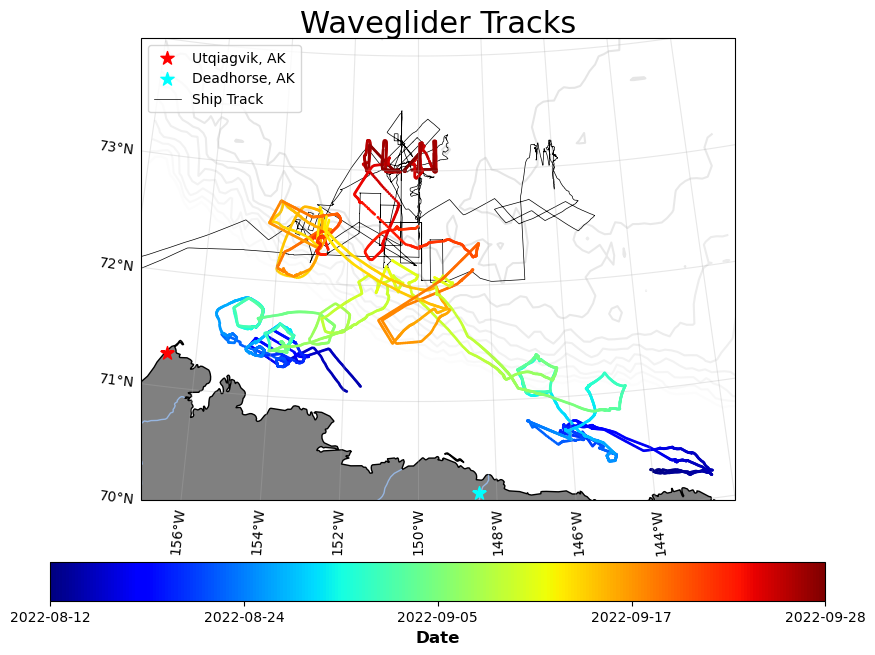

In [31]:
map_wavegliders()

In [56]:
##USE THIS TO MAP WAVEGLIDER VARIABLES 
def map_waveglider_variable(wg_number,var,var_min,var_max,ice_data=False,ship_track=True,bathymetry_data=True):
     
    ##LOAD IN DATA FROM SELECTED WAVEGLIDER
    file = dir_in+'SASSIE_Fall_2022_Waveglider_'+str(wg_number)+'.nc'
    ds = xr.open_dataset(file,engine='netcdf4')
    wg_lat = ds['latitude']
    wg_lon = ds['longitude']
    wg_time = ds['time']
    wg_var = ds[var]
    
    ##CREATE A MAP WITH LAND AND CITY MARKERS  
    latmin = 70
    latmax =74
    lonmin=-158
    lonmax=-142
    
    colormap,var_label = define_var_attributes(var)
          
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=cartopy.crs.NorthPolarStereo(central_longitude=-150))
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=cartopy.crs.PlateCarree())
    ax.coastlines(color='k')  
    ax.add_feature(cartopy.feature.LAND, facecolor = '0.50')
    ax.add_feature(cartopy.feature.RIVERS,facecolor='blue')
    
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.3) #draw_labels=True gives lat labels. 
    ax.set_title('Waveglider '+str(wg_number)+' '+var_label+' Readings',fontsize=15)
    xticks = list(np.linspace(lonmin,lonmax,4))
    yticks = list(np.linspace(latmin,latmax,3))
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(60,75,1))
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-170,-138,2))
    gl.top_labels = False
    gl.bottom_labels = True #change to tru to add lon labels
    gl.right_labels = False
    
    if (latmin<71.2906) & (lonmin<-156.7886):
        utqiagvik = ax.scatter(-156.7886,71.2906,s=100,transform=cartopy.crs.PlateCarree(),c='red',marker = '*',label='Utqiagvik, AK')
    if (latmin<70.2002) & (lonmax>-148.4597):
        deadhorse = ax.scatter(-148.4597,70.2002,s=100,c='cyan',transform=cartopy.crs.PlateCarree(),marker = '*',label='Deadhorse, AK')
    
    ##OPTIONAL MAP ADD-ONS
    if ship_track==True:
        ##ADD SHIP TRACK DATA
        ds_ship = xr.open_dataset(ship_dir)
        ship_time = np.squeeze(ds_ship['time'])
        ship_lat = np.squeeze(ds_ship['latitude'])
        ship_lon = np.squeeze(ds_ship['longitude'])
        apply_ship_track = ax.scatter(ship_lon,ship_lat,s = 1,c='black',transform=cartopy.crs.PlateCarree(),alpha = 0.002,zorder = 1)
    
    if bathymetry_data ==True:
        ##ADD BATHYMETRY DATA
        topoin = etopodata.rose.values[0:-1:5,1:-1:5]
        lons = etopodata.etopo2_x.values[0:-1:5]
        lats = etopodata.etopo2_y.values[0:-1:5]
        lons_in_range = lons[np.where((lons >lonmin-1) & (lons<lonmax+1))]
        lats_in_range = lats[np.where((lats >latmin-1) & (lats<latmax+1))]
        topo_in_range = np.squeeze(topoin[np.squeeze(np.where((lats >latmin-1) & (lats<latmax+1))),:][:,np.where((lons >lonmin-1) & (lons<lonmax+1))])
        [bathy_lon,bathy_lat] = np.meshgrid(lons_in_range,lats_in_range)

        bathy = ax.contour(bathy_lon,bathy_lat,topo_in_range,np.arange(-6000,-1000,300),transform=cartopy.crs.PlateCarree(),cmap='gray',alpha = 0.2,zorder = 0)
    
    if ice_data ==True: 
        ##ADD ICE DATA
        #get ice data at start of time range
        start_time = pd.to_datetime(min(wg_time.values),'ns')
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        i=0
        time_tmp=start_time - timedelta(days=i)
        while os.path.isfile(str(ice_dir)+'/'+filename_si)==False and i<15:
            time_tmp=start_time - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
            with open(str(ice_dir)+'/'+filename_si, 'wb') as f:
                f.write(url.content)
            i=i+1

        #get ice data at end of time range 
        end_time = pd.to_datetime(max(wg_time.values),'ns')
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+'.he5' 
        i=0
        time_tmp=end_time - timedelta(days=i)
        while os.path.isfile(str(ice_dir)+'/'+filename_si)==False and i<15:
            time_tmp=end_time - timedelta(days=i)
            filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(time_tmp.year)+str(time_tmp.month).zfill(2)+str(time_tmp.day).zfill(2)+'.he5'
            try:
                url = requests.get('https://n5eil01u.ecs.nsidc.org/AMSA/AU_SI12.001/'+str(time_tmp.year)+'.'+str(time_tmp.month).zfill(2)+'.'+str(time_tmp.day).zfill(2)+'/'+filename_si)
                with open(str(ice_dir)+'/'+filename_si, 'wb') as f:
                    f.write(url.content)     
            except:
                pass
            i=i+1

        #apply ice data at the end of the time range (ice sheet growth) in red
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(end_time.year)+str(end_time.month).zfill(2)+str(end_time.day).zfill(2)+'.he5' 
        if os.path.isfile(str(ice_dir)+'/'+filename_si):
            dsc = xr.open_dataset(str(ice_dir)+'/'+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(str(ice_dir)+'/'+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))

            var1[indx] = 0
            ice_growth_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_growth_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Reds_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())

        #apply ice data at the start of the time range in blue
        filename_si='AMSR_U2_L3_SeaIce12km_B04_'+str(start_time.year)+str(start_time.month).zfill(2)+str(start_time.day).zfill(2)+'.he5' 
        if os.path.isfile(str(ice_dir)+'/'+filename_si):
            dsc = xr.open_dataset(str(ice_dir)+'/'+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km')
            dsd = xr.open_dataset(str(ice_dir)+'/'+filename_si,group='HDFEOS/GRIDS/NpPolarGrid12km/Data Fields') 
            var1 = np.array(dsd.SI_12km_NH_ICECON_DAY.squeeze().values)
            indx = np.where((var1==120) | (var1==0))
            var1[indx] = 0
            ice_location = np.ma.masked_where(var1==0,var1)

            pp = ax.pcolormesh(dsc.lon,dsc.lat,ice_location, 
                            vmin=0,vmax=100, # Set max and min values for plotting
                            cmap='Blues_r', shading='auto',   # shading='auto' to avoid warning
                            transform=cartopy.crs.PlateCarree())
    
    ##APPLY WAVEGLIDER DATA 
    wg_track = ax.scatter(wg_lon, 
                 wg_lat,s=5, 
                 c=wg_var,cmap=colormap,
                   transform=cartopy.crs.PlateCarree(),
                      vmin = var_min,
                      vmax = var_max,zorder = 2)
    
    plt.legend(loc=2)           
    matplotlib.pyplot.colorbar(wg_track, ax=ax, orientation="horizontal", pad=0.1).set_label(label=var_label,size='large',weight='bold')
    
    
    #SAVE FIGURE 
    if not os.path.exists(fig_dir+ var):
        os.makedirs(fig_dir+var)
    print('Saving Output Image:  '+fig_dir+var+'/Waveglider'+str(wg_number)+'.png')
    plt.savefig(fig_dir+var+'/Waveglider'+str(wg_number)+var+'.png',dpi='figure',format='png')
    
    
    

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/wavegliders/salinity/Waveglider130.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/wavegliders/salinity/Waveglider153.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/wavegliders/salinity/Waveglider245.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/wavegliders/salinity/Waveglider247.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


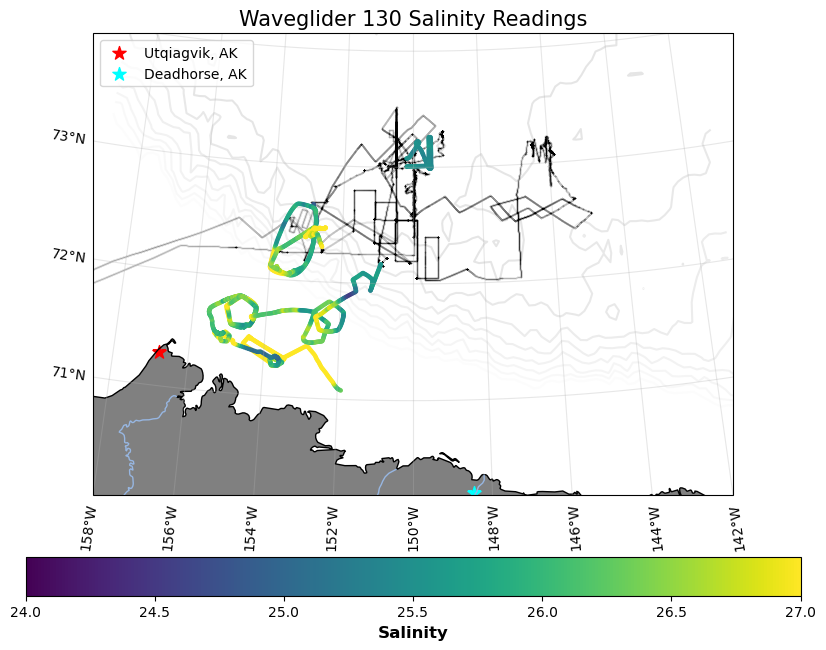

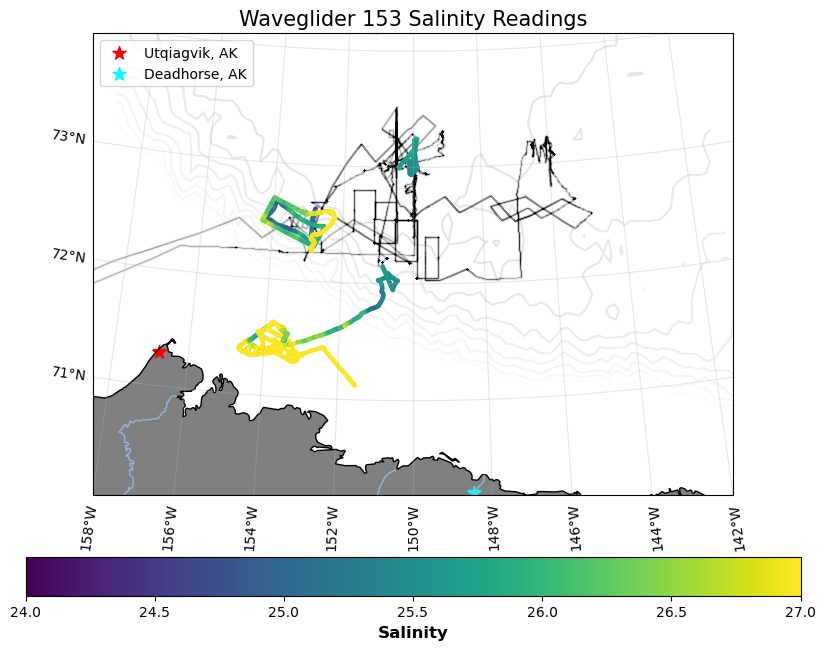

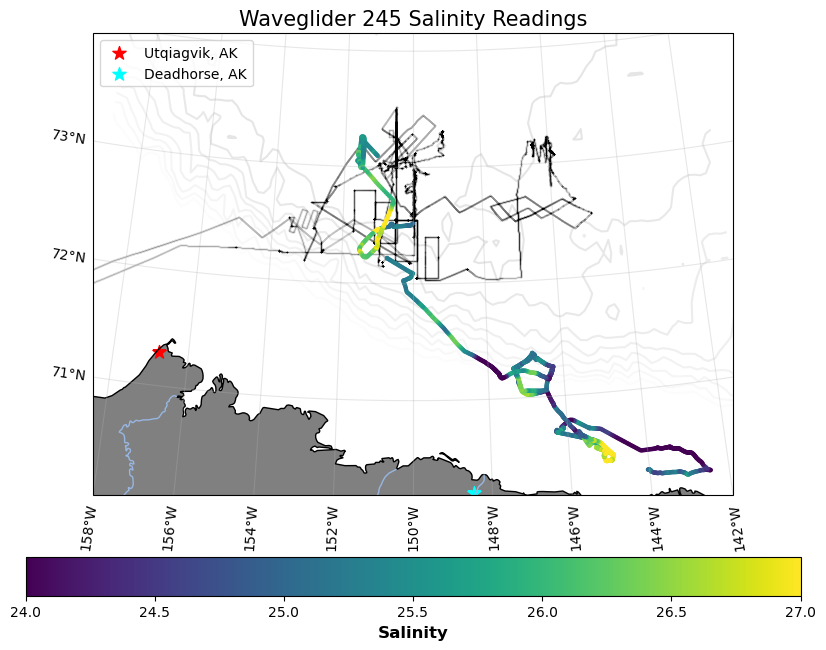

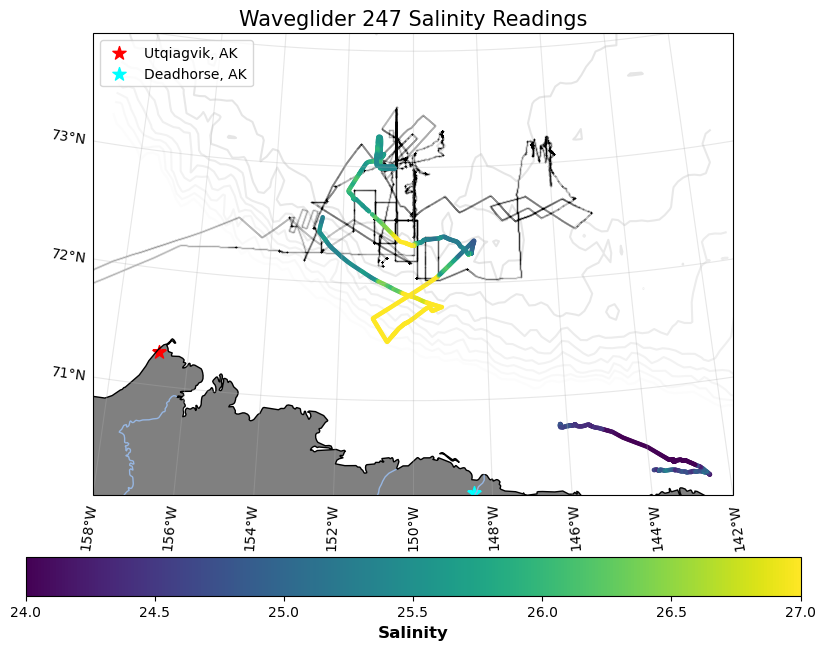

In [57]:
map_waveglider_variable(130,'salinity',24,27)
map_waveglider_variable(153,'salinity',24,27)
map_waveglider_variable(245,'salinity',24,27)
map_waveglider_variable(247,'salinity',24,27)

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/wavegliders/water_temperature/Waveglider130.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/wavegliders/water_temperature/Waveglider153.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/wavegliders/water_temperature/Waveglider245.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/wavegliders/water_temperature/Waveglider247.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


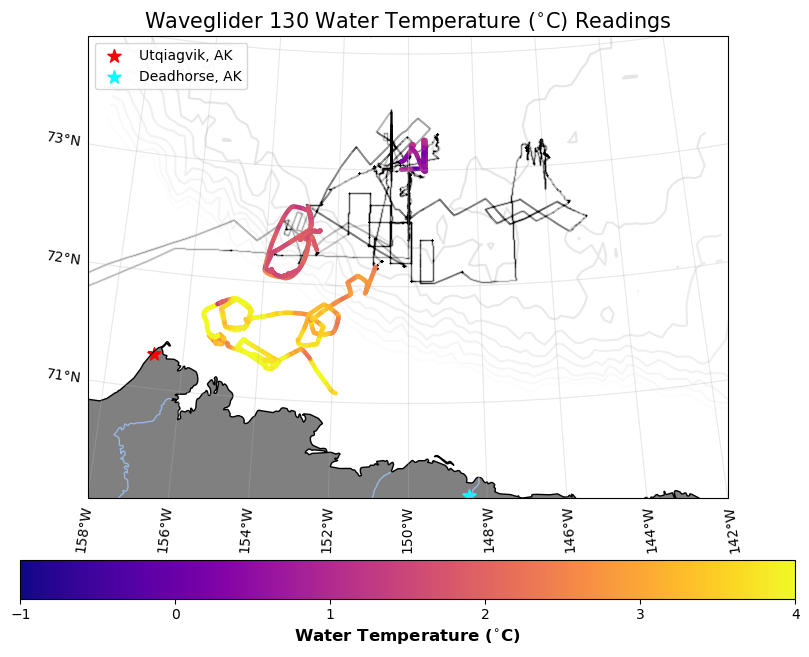

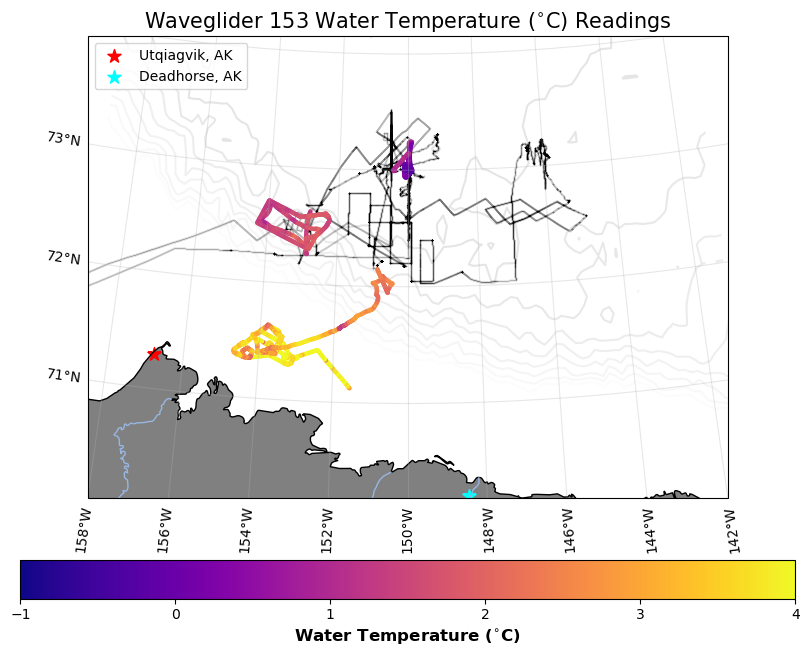

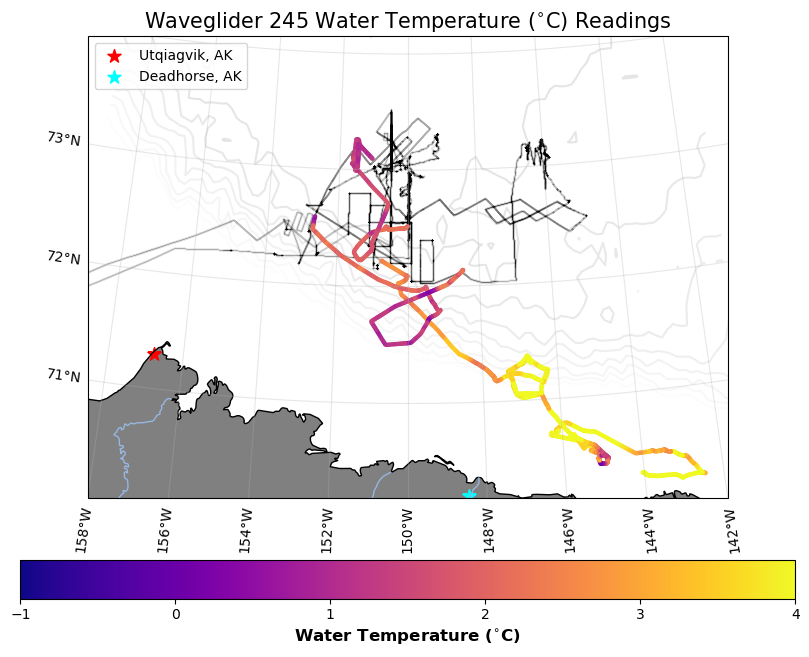

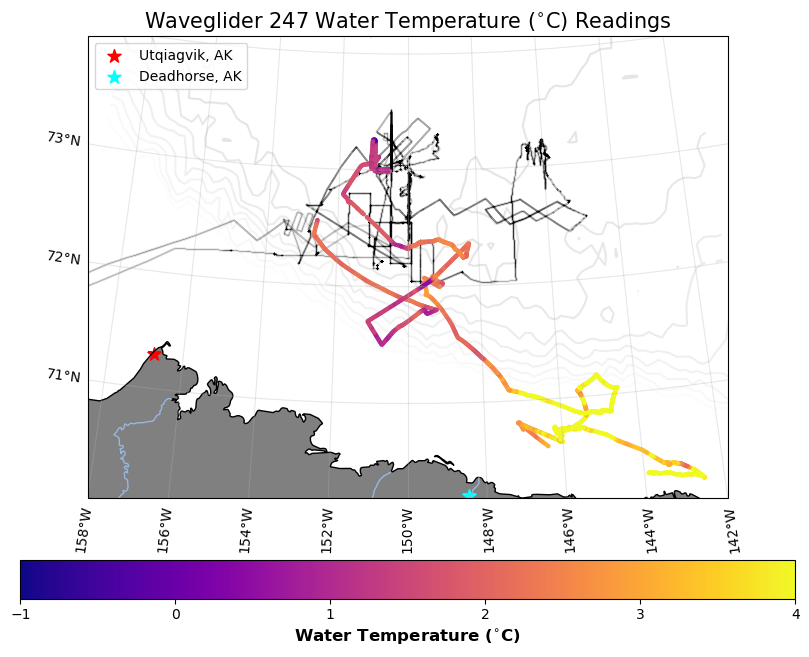

In [58]:
map_waveglider_variable(130,'water_temperature',-1,4)
map_waveglider_variable(153,'water_temperature',-1,4)
map_waveglider_variable(245,'water_temperature',-1,4)
map_waveglider_variable(247,'water_temperature',-1,4)

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/wavegliders/air_temperature/Waveglider130.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/wavegliders/air_temperature/Waveglider153.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/wavegliders/air_temperature/Waveglider245.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/wavegliders/air_temperature/Waveglider247.png


/Users/westbrooke/opt/anaconda3/envs/SASSIE_Data/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


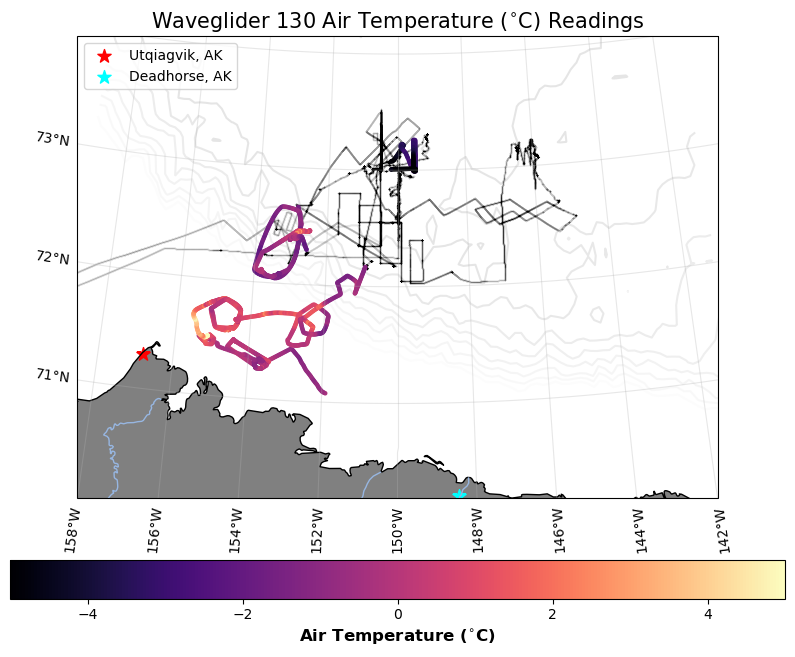

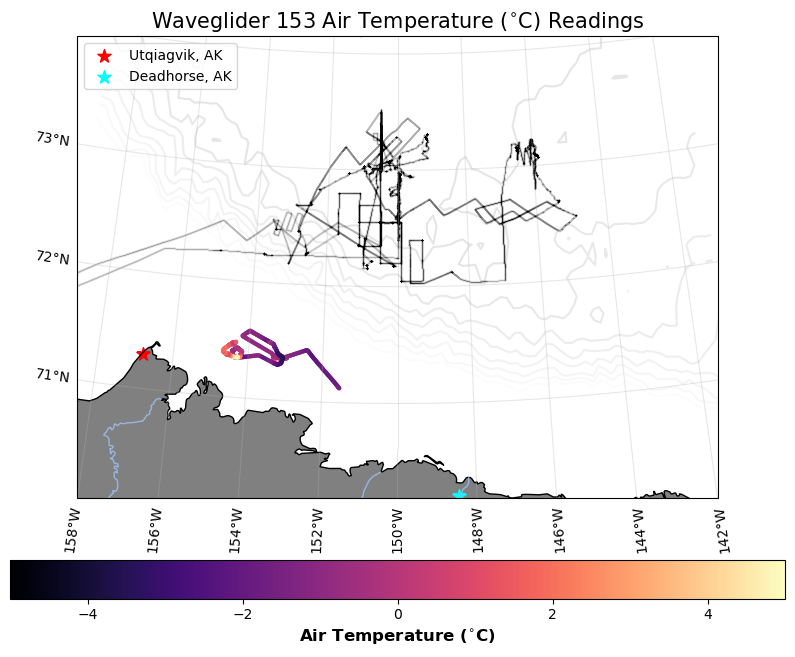

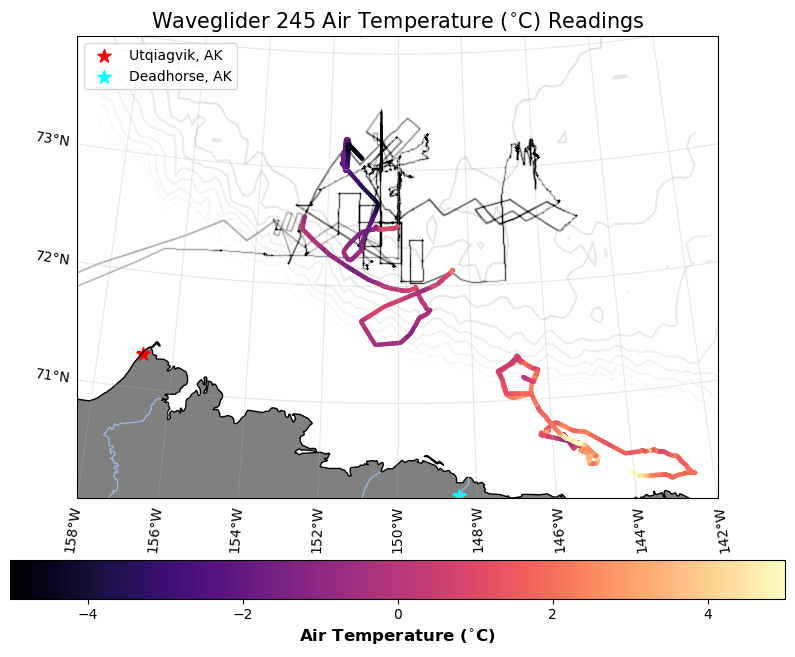

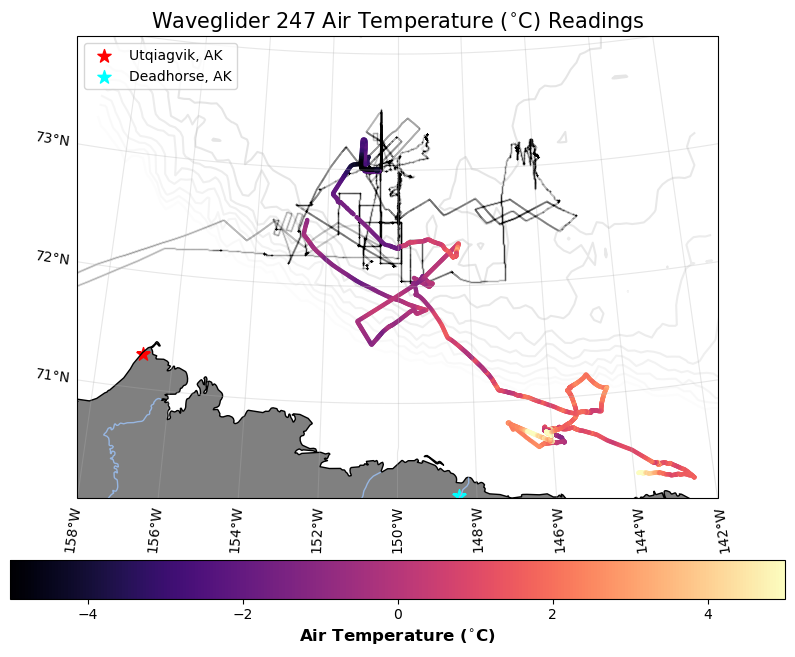

In [59]:
map_waveglider_variable(130,'air_temperature',-5,5)
map_waveglider_variable(153,'air_temperature',-5,5)
map_waveglider_variable(245,'air_temperature',-5,5)
map_waveglider_variable(247,'air_temperature',-5,5)

In [60]:
def plot_waveglider_timeseries(wg_number,var1,var2,var3): 
    
    #SECLECT AND LOAD WAVEGLIDER DATA
    file = dir_in+'SASSIE_Fall_2022_Waveglider_'+str(wg_number)+'.nc'
    ds = xr.open_dataset(file)
    time_data = ds['time']
    [colormap,var1_label] = define_var_attributes(var1)
    [colormap,var2_label] = define_var_attributes(var2)
    [colormap,var3_label] = define_var_attributes(var3)
    var1_data = ds[var1]
    var2_data = ds[var2]
    var3_data = ds[var3]
        
    #MAKE A THREE PANELED TIME SERIES PLOT
    fig,axs = plt.subplots(3,sharex=True)
    
    axs[0].plot(time_data,var1_data,c='black',linewidth=0.4)
    axs[0].set(ylabel=var1_label)
    axs[1].plot(time_data,var2_data,c='black',linewidth=0.4)
    axs[1].set(ylabel=var2_label)
    axs[2].plot(time_data,var3_data,c='black',linewidth=0.4)
    axs[2].set(ylabel=var3_label,xlabel = 'Date')
    
    plt.xticks(pd.date_range(start=time_data.values[0],end=time_data.values[-1],periods=3))
    fig.suptitle(var1_label+', '+var2_label+', and '+var3_label+' Data from Waveglider '+str(wg_number),fontsize=10)
        
    ##SAVE FIGURE 
    if not os.path.exists(fig_dir+'/timeseries'):
        os.makedirs(fig_dir+'/timeseries')
    print('Saving Output Image:  '+fig_dir+'timeseries/Waveglider'+str(wg_number)+'_'+var1+'_'+var2+'_'+var3+'.png')
    plt.savefig(fig_dir+'timeseries/Waveglider'+str(wg_number)+'_'+var1+'_'+var2+'_'+var3+'.png',dpi='figure',format='png')
    

Saving Output Image:  /Users/westbrooke/Library/CloudStorage/OneDrive-UNC-Wilmington/SASSIE/communication/notebooks_images/wavegliders/timeseries/Waveglider245_water_temperature_salinity_wind_speed.png


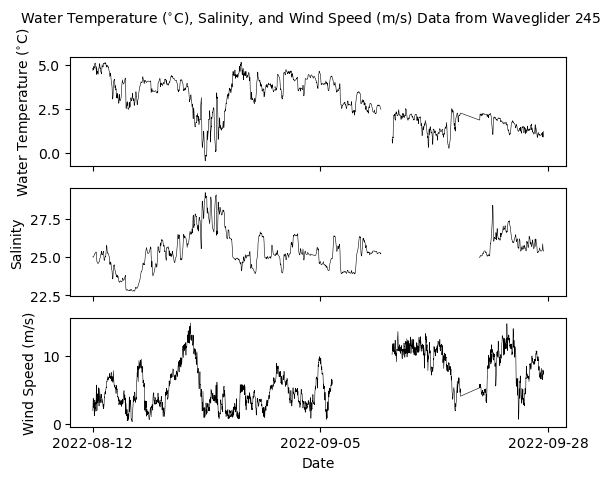

In [61]:
plot_waveglider_timeseries(245,'water_temperature','salinity','wind_speed')